# Note sur les cartes cognitives

V2, après nouvelles enquêtes VBO et reprise du thésaurus.

## TODO

- [x] mettre le GAD en catégories/intervalles
  - en `str` c'est OK
- [x] faire l'histo des occ "à la zipf"
- [ ] mixte / le minier / non minier "officiel" ?
  - à étudier
- [ ] créer un premier niveau "nettoyage" du thésaurus
- les mots à problème (polysémie) comme _caillou_
  - une catégorie des `nulls` ? Voir `S.i`
  - accepter un thésaurus à trou

## Notes sur les données

### A l'usage du producteur

Pour faciliter le traitement automatique, assurer la qualité des données

- apostrophe avant date
- espace/majuscules surperflues : respecter l'orthographe, supprimer les articles inutiles, forme fléchies
  - penser à _un dictionnaire_
- colonnes duppliquées (calcul si besoin)
- colonnes de même nom
- colonnes au nom ambigu
- numéro au delà des utilisés
- pas de mise en forme en utilisant des cellules vides

### Notes techniques

- rester tant que possible sur un `DataFrame`,
  - ne pas mixer / casser la srtucture,
  - ou alors, _once and for all_ e.g., pour la liste de réponses,
- assurer la cohérence de la clef : OK (au 2022-05-31)
- gérer les libellés des questions
- la représentation des durées/ages (`ans`)


## Chargement et préparation du jeu de données

On commence par charger le fichier excel et les onglets.


In [130]:
import operator as op
from collections import defaultdict
from itertools import pairwise

from datetime import date
from pathlib import Path
from collections import Counter
from statistics import fmean

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from catk import CA

# nombre max de mots énoncables = nb colonnes source XLS
MAX_COLS = 20
XLS_SOURCE = Path("../input/BDD_2022-06-22.xlsx")

# Noms des onglets
SHEET_THESAURUS = "Thésaurus"
SHEET_BDD = "BDD"
SHEET_QUESTIONS = "Questions"
SHEET_MOTS = "Mots"

# préfixes des colonnes des mots énoncés
PREFIX_MINE = "Mine"
PREFIX_FUTUR = "Futur"

# noms des cartes
LABEL_MINE = "la mine et le nickel"
LABEL_FUTUR = "la mine dans le futur"

TOP_K_WORDS = 20

# mots sans signification, supprimé du thésaurus
INCONNU = "S.i"

cols_mine = [f"{PREFIX_MINE} {i}" for i in range(1, MAX_COLS + 1)]
cols_futur = [f"{PREFIX_FUTUR} {i}" for i in range(1, MAX_COLS + 1)]
cols_censurees = [f"Question {x}" for x in [2, 5.1, 7, 10.1, 11, 14, 14.1]] + ["Commentaire entretien/individu"]


# petit outillage
def clean(s: str) -> str:
    """Nettoyage de chaines"""
    if not isinstance(s, str):
        raise TypeError(f"'{s}' is of type {type(s)}")
    return s.strip().lower()


def pretty_pvals(x):
    """Affichage de courtoisie des niveaux de significativité statistique"""
    if x < 1e-4:
        return "****"
    if x < 1e-3:
        return "***"
    if x < 1e-2:
        return "**"
    if x < 5e-2:
        return "*"
    return ""


Chargement du jeu de données puis division du jeu de données en :

- données personnelles répondant
- cartes la mine
- cartes le futur


In [2]:
df_complete = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_BDD, index_col="Numéro")

# ajout des groupes d'ages quinquennaux/décénaux GAD et GAQ
df_complete["GAD"] = (10 * (df_complete["Question 12"] // 10))
df_complete["GAQ"] = (5 * (df_complete["Question 12"] // 5))

print("Liste des colonnes disponibles")
display(df_complete.columns)


Liste des colonnes disponibles


Index(['Date', 'Commune d’enquête', 'Collecte directe',
       'Commentaire entretien/individu', 'Question 1', 'Question 2',
       'Question 3', 'Question 4', 'Question 5', 'Question 5.1', 'Question 6',
       'Question 7', 'Question 8', 'Question 8.1', 'Question 8.2',
       'Question 9', 'Question 10', 'Question 10.1', 'Question 11',
       'Question 12', 'Question 13', 'Question 14', 'Question 14.1', 'Mine 1',
       'Mine 2', 'Mine 3', 'Mine 4', 'Mine 5', 'Mine 6', 'Mine 7', 'Mine 8',
       'Mine 9', 'Mine 10', 'Mine 11', 'Mine 12', 'Mine 13', 'Mine 14',
       'Mine 15', 'Mine 16', 'Mine 17', 'Mine 18', 'Mine 19', 'Mine 20',
       'Futur 1', 'Futur 2', 'Futur 3', 'Futur 4', 'Futur 5', 'Futur 6',
       'Futur 7', 'Futur 8', 'Futur 9', 'Futur 10', 'Futur 11', 'Futur 12',
       'Futur 13', 'Futur 14', 'Futur 15', 'Futur 16', 'Futur 17', 'Futur 18',
       'Futur 19', 'Futur 20', 'GAD', 'GAQ'],
      dtype='object')

In [3]:
cols_resp = [c for c in df_complete.columns if c not in cols_mine + cols_futur + cols_censurees]

df_resp = df_complete[cols_resp]
df_resp.name = "Données personnelles"
df_mine = df_complete[cols_mine].astype("string")
df_mine.name = f"Cartes cognitives '{LABEL_MINE}'"
df_futur = df_complete[cols_futur].astype("string")
df_futur.name = f"Cartes cognitives '{LABEL_FUTUR}'"

print(f"Nombre de répondants {len(df_complete)}")
print(f"Colonnes '{LABEL_MINE}' présentes {set(cols_mine) <= set(df_complete.columns)}")
print(f"Colonnes '{LABEL_FUTUR}' présentes {set(cols_futur) <= set(df_complete.columns)}")


Nombre de répondants 508
Colonnes 'la mine et le nickel' présentes True
Colonnes 'la mine dans le futur' présentes True


### Informations personnelles des répondants

In [4]:
df_questions = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_QUESTIONS, parse_dates=False).astype(
    {"Question": "string", "Libellé": "string"}
)

print(f"Toutes les questions posées bien présentes chez les répondants {set(df_questions['Question']) <= (set(df_resp.columns) | set(cols_censurees))}")
display(df_questions)

# mise sous forme de dictionnaire pour remplacer les questions par leurs labels dans les résultats/légendes
questions_labels = df_questions.set_index("Question").to_dict()["Libellé"]  # orient="series"


Toutes les questions posées bien présentes chez les répondants True


,Question,Libellé
0,Question 1,Travaillez-vous ou avez travaillez pour l’indu...
1,Question 2,"Si oui, quel(s) étai(en)t votre/vos poste(s) ?"
2,Question 3,Depuis combien de temps travaillez-vous ou pen...
3,Question 4,Un membre de votre famille travaille t’il ou a...
4,Question 5,Avez-vous toujours vécu en Nouvelle-Calédonie ?
5,Question 5.1,"Si non, d’où venez-vous ?"
6,Question 6,"Si non, depuis combien de temps vivez-vous en ..."
7,Question 7,"Si non, pourquoi vous êtes vous installé(e) en..."
8,Question 8,Où habitez-vous ? (Le plus précis possible san...
9,Question 8.1,Commune de résidence.


### Vérifications et indicateurs globaux

Création des dictionnaires de réponses sur les deux enquêtes avec quelques statistiques

In [5]:
# fonction outil pour transformer le dataframe en dictionnaire des mots énoncés
def get_cogmaps(df, cols):
    return {idx: [clean(val) for val in vals.dropna().tolist()] for idx, vals in df[cols].astype("string").iterrows()}


# les deux dictionnaire principaux
dict_mine = get_cogmaps(df_complete, cols_mine)
dict_futur = get_cogmaps(df_complete, cols_futur)

for dic, lbl in ((dict_mine, LABEL_MINE), (dict_futur, LABEL_FUTUR)):
    print(f"Cartes '{lbl}'")
    print(f"\tplus longue cartes {max(len(val) for val in dic.values())}")
    print(f"\tlongueur moyenne des cartes {fmean(len(val) for val in dic.values()):.2f}")
    print(f"\tnombre total de mots énoncés {sum(len(val) for val in dic.values())}")
    print(f"\tnombre de mots énoncés différents {len(set(v for val in dic.values() for v in val))}")
    print()


Cartes 'la mine et le nickel'
	plus longue cartes 20
	longueur moyenne des cartes 7.61
	nombre total de mots énoncés 3865
	nombre de mots énoncés différents 902

Cartes 'la mine dans le futur'
	plus longue cartes 18
	longueur moyenne des cartes 4.68
	nombre total de mots énoncés 2376
	nombre de mots énoncés différents 903



Les mots énoncés les plus cités

In [6]:
for dic, lbl in ((dict_mine, LABEL_MINE), (dict_futur, LABEL_FUTUR)):
    words = Counter(w for l in dic.values() for w in l)
    print(f"Cartes '{lbl}' : {len(words)} mots. Top {TOP_K_WORDS}, toutes positions confondues :")
    display(words.most_common(TOP_K_WORDS))


Cartes 'la mine et le nickel' : 902 mots. Top 20, toutes positions confondues :


[
    ('nickel', 189),
    ('pollution', 182),
    ('économie', 116),
    ('camion', 104),
    ('travail', 100),
    ('environnement', 100),
    ('emploi', 97),
    ('usine', 89),
    ('montagne', 77),
    ('argent', 76),
    ('richesse', 74),
    ('terre', 73),
    ('exploitation', 65),
    ('minerai', 65),
    ('destruction', 60),
    ('ressource', 56),
    ('sln', 54),
    ('conflit', 52),
    ('déforestation', 42),
    ('caillou', 38)
]

Cartes 'la mine dans le futur' : 903 mots. Top 20, toutes positions confondues :


[
    ('pollution', 122),
    ('économie', 55),
    ('environnement', 50),
    ('emploi', 49),
    ('ressource', 43),
    ('épuisement', 32),
    ('destruction', 32),
    ('conflit', 28),
    ('richesse', 26),
    ('technologie', 24),
    ('développement', 24),
    ('montagne', 22),
    ('travail', 21),
    ('impact', 21),
    ('reboisement', 20),
    ('disparition', 20),
    ('argent', 18),
    ('fin', 18),
    ('exploitation', 18),
    ('épuisable', 17)
]

Longueur des cartes et leur histogramme


Répartitions des longueurs des cartes


<Figure size 432x288 with 1 Axes>

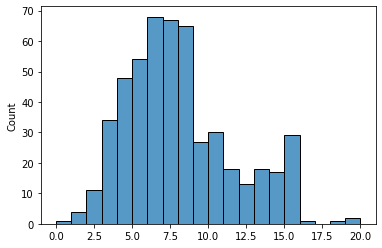

<Figure size 432x288 with 1 Axes>

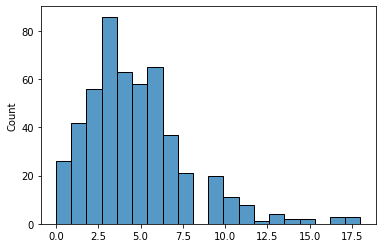

In [7]:
def get_n_words(dic, n: int):
    """Mot de la position n"""
    return [vals[n] for vals in dic.values() if n < len(vals)]


print("Répartitions des longueurs des cartes")
sns.histplot([len(vals) for vals in dict_mine.values()], bins=20)
plt.show()
sns.histplot([len(vals) for vals in dict_futur.values()], bins=20)
plt.show()


## Quelques indicateurs sur les profils des répondants


Histogramme des ages des répondants


<AxesSubplot:xlabel='Question 12', ylabel='Count'>

<Figure size 432x288 with 1 Axes>

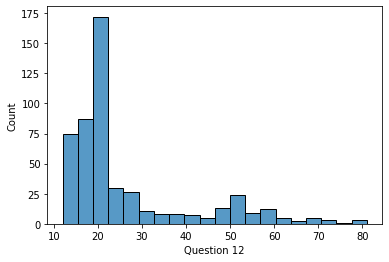

In [8]:
print("Histogramme des ages des répondants")
sns.histplot(df_resp["Question 12"], bins=20)

On va calculer les effectifs du nombre de personnes pour les valeurs prises par quelques questions.


In [9]:
# fonction outil pour les calculs d'effectifs
def groupby(questions):
    """Prend une liste de questions, fait le group by et renomme les colonnes"""
    return df_complete.value_counts(subset=questions, sort=False).rename_axis(
        [questions_labels.get(q, q) for q in questions]
    )


display(groupby(["Question 1", "Question 4"]))
display(groupby(["Question 8.1"]).sort_values())
display(groupby(["GAD", "Question 8.2"]))


Travaillez-vous ou avez travaillez pour l’industrie minière ou métallurgique ?  Un membre de votre famille travaille t’il ou a t’il travaillé pour cette industrie ?
Non                                                                             Non                                                                                     136
                                                                                Oui                                                                                     300
Oui                                                                             Non                                                                                      12
                                                                                Oui                                                                                      55
dtype: int64

Commune de résidence.
Île des Pins               1
Koumac                     1
La Foa                     1
Paris                      1
Moindou                    1
Voh                        2
Kaala-Gomen                2
Ponérihouen                2
Pouébo                     3
Pouembout                  3
Poya                       4
Poindimié                  4
Ouégoa                     4
Boulouparis                4
Houaïlou                   4
Maré                       6
Koné                       7
Bourail                    7
Lifou                     10
Touho                     11
Thio                      16
Yaté                      30
Païta                     37
Dumbéa                    61
Mont-Dore                 80
Hienghène                 96
Nouméa                   109
dtype: int64

GAD   Distinction communes minières ; non-minière et mixte (Nouméa)
10.0  Minière                                                           64
      Mixte                                                             46
      Non minière                                                      121
20.0  Minière                                                           29
      Mixte                                                             54
      Non minière                                                       75
30.0  Minière                                                           13
      Mixte                                                              3
      Non minière                                                       11
40.0  Minière                                                           14
      Mixte                                                              4
      Non minière                                                        7
50.0  Minière                                                           18
      Mixte                                                              7
      Non minière                                                       16
60.0  Minière                                                            7
      Non minière                                                        8
70.0  Minière                                                            1
      Mixte                                                              2
      Non minière                                                        3
80.0  Minière                                                            2
dtype: int64

#### Répartition GAD/commune

In [10]:
s = pd.DataFrame(groupby(["GAD", "Question 8.1"])).reset_index().rename(columns={0: "Nb"})  # .to_csv("test.csv")
s.pivot(index="Commune de résidence.", columns="GAD").fillna(0).astype(int)


Nb 
 
 
 GAD 
 10.0 
 20.0 
 30.0 
 40.0 
 50.0 
 60.0 
 70.0 
 80.0 
 
 
 Commune de résidence. 
 
 
 
 
 
 
 
 
 
 
 
 
 Boulouparis 
 3 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Bourail 
 2 
 3 
 0 
 1 
 1 
 0 
 0 
 0 
 
 
 Dumbéa 
 23 
 28 
 2 
 2 
 3 
 2 
 0 
 0 
 
 
 Hienghène 
 65 
 8 
 6 
 3 
 6 
 5 
 2 
 0 
 
 
 Houaïlou 
 0 
 1 
 3 
 0 
 0 
 0 
 0 
 0 
 
 
 Kaala-Gomen 
 0 
 2 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Koné 
 3 
 2 
 1 
 1 
 0 
 0 
 0 
 0 
 
 
 Koumac 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 La Foa 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Lifou 
 3 
 6 
 0 
 1 
 0 
 0 
 0 
 0 
 
 
 Maré 
 1 
 5 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Moindou 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Mont-Dore 
 50 
 18 
 1 
 5 
 6 
 0 
 0 
 0 
 
 
 Nouméa 
 43 
 51 
 3 
 3 
 7 
 0 
 2 
 0 
 
 
 Ouégoa 
 0 
 4 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Paris 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Païta 
 13 
 14 
 3 
 0 
 5 
 1 
 1 
 0 
 
 
 Poindimié 
 1 
 3 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Ponérihouen 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Pouembout 
 0 
 1 
 2 
 0 
 0 
 0 
 0 
 0 
 
 
 Pouébo 
 0 
 3 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Poya 
 3 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 
 
 Thio 
 1 
 1 
 1 
 6 
 4 
 3 
 0 
 0 
 
 
 Touho 
 11 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Voh 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Yaté 
 4 
 4 
 5 
 2 
 8 
 4 
 1 
 2 
 
 
 Île des Pins 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0

#### Répartition commune/type commune

In [11]:
s = pd.DataFrame(groupby(["Question 8.1", "Question 8.2"])).reset_index().rename(columns={0: "Nb"})  # .to_csv("test.csv")
s.pivot(index="Commune de résidence.", columns="Distinction communes minières ; non-minière et mixte (Nouméa)").fillna(0).astype(int)


Nb 
 
 
 Distinction communes minières ; non-minière et mixte (Nouméa) 
 Minière 
 Mixte 
 Non minière 
 
 
 Commune de résidence. 
 
 
 
 
 
 
 
 Boulouparis 
 4 
 0 
 0 
 
 
 Bourail 
 0 
 0 
 7 
 
 
 Dumbéa 
 0 
 0 
 61 
 
 
 Hienghène 
 0 
 1 
 95 
 
 
 Houaïlou 
 4 
 0 
 0 
 
 
 Kaala-Gomen 
 2 
 0 
 0 
 
 
 Koné 
 1 
 6 
 0 
 
 
 Koumac 
 1 
 0 
 0 
 
 
 La Foa 
 0 
 0 
 1 
 
 
 Lifou 
 0 
 0 
 10 
 
 
 Maré 
 0 
 0 
 6 
 
 
 Moindou 
 0 
 0 
 1 
 
 
 Mont-Dore 
 80 
 0 
 0 
 
 
 Nouméa 
 0 
 109 
 0 
 
 
 Ouégoa 
 0 
 0 
 4 
 
 
 Païta 
 0 
 0 
 37 
 
 
 Poindimié 
 0 
 0 
 4 
 
 
 Ponérihouen 
 0 
 0 
 2 
 
 
 Pouembout 
 3 
 0 
 0 
 
 
 Pouébo 
 0 
 0 
 3 
 
 
 Poya 
 4 
 0 
 0 
 
 
 Thio 
 16 
 0 
 0 
 
 
 Touho 
 1 
 0 
 10 
 
 
 Voh 
 2 
 0 
 0 
 
 
 Yaté 
 30 
 0 
 0 
 
 
 Île des Pins 
 0 
 0 
 1

## Mots énoncés les plus communs pour la carte "la mine"

On va segmenter les données en _populations_ (e.g., "moins de 26 ans", "mineur", etc.) selon les attributs et générer un tableau avec :

- en ligne tous les mots énoncés dans les cartes "la mine"
- en colonne, les populations, avec pour chacune :
  - le nombre de fois où le mot a été énoncé par les membres de cette population
  - le nombre de fois "théorique" où le mot serait annoncé si il y avait indépendance des énonciations entre les populations
  - le % de fois où un membre de la population a énoncé le mot
- pour chaque groupe, on calcule ensuite un test du $\chi^2$ pour évaluer l'écart à l'indépendance


In [12]:
THRESHOLD_MIN_ENONCIATIONS = 20
LABEL_TOTAL = "Total"
ALL_SYMB = "*"
CLEF_TOTAL = (ALL_SYMB, ALL_SYMB, LABEL_TOTAL)


# comptage du nombre d'occurence total, en oubliant les répondants
all_words_mine = Counter(w for l in dict_mine.values() for w in l)
all_words_futur = Counter(w for l in dict_futur.values() for w in l)

# transformation en DF
df_enonces = pd.DataFrame(index=list(all_words_mine.keys()))
df_enonces[CLEF_TOTAL] = all_words_mine.values()

# filtrage au dessus du seuil et tri
df_enonces = df_enonces[df_enonces[CLEF_TOTAL] >= THRESHOLD_MIN_ENONCIATIONS]
df_enonces.sort_values(CLEF_TOTAL, key=op.neg, inplace=True)
display(df_enonces)


,"(*, *, Total)"
nickel,189
pollution,182
économie,116
camion,104
travail,100
environnement,100
emploi,97
usine,89
montagne,77
argent,76


## Tableau de comparaison des mots énoncés par profil du répondant

**NB** Ici un gros point méthodologique : on va faire un test d'indépendance statistique $\chi^2$ sur les mots énoncés les plus fréquents afin de déterminer si leurs énonciations sont indépendantes ou pas des profils des répondants.

In [13]:
def add_population(df_population, filtres, name):
    """Ajout de colonnes au df de synthèse des profils sur une population segmentée"""
    observed = []
    expected = []
    chi2 = stats.chi2(len(filtres) - 1)
    for filtre, val in filtres:
        cg = get_cogmaps(df_mine[filtre], cols_mine)
        c = Counter(w for l in cg.values() for w in l)
        print(f"Ajout de la colonne '{name}, {val}', {len(cg)} répondants, {c.total()} énonciations")

        key = (name, val, "Nb.")
        df_population[key] = pd.Series(c)
        df_population[key].fillna(0, inplace=True)
        df_population[key] = df_population[key].astype(int)


        # ici en % ** des répondants**
        df_population[(name, val, "Nb. th.")] = round(df_population[CLEF_TOTAL] * len(cg) / len(df_mine), 2)
        exp = df_population[CLEF_TOTAL].to_numpy() * len(cg) / len(df_mine)

        observed.append(df_population[key].to_numpy().reshape(-1, 1))
        expected.append(exp.reshape(-1, 1))

    obs, exp = np.concatenate(observed, axis=1), np.concatenate(expected, axis=1)
    chis = np.sum((obs - exp) ** 2 / exp, axis=1)
    p_vals = chi2.sf(chis)
    df_population[(name, "Chi²", "Significatif")] = [pretty_pvals(v) for v in p_vals]


def generate_all_filters(col):
    values = df_resp[col].dropna().unique()
    return [(df_resp[col] == value, value) for value in values]


moins_de_26_ans = df_resp["Question 12"] < 26
add_population(df_enonces, [(moins_de_26_ans, "Oui"), (~moins_de_26_ans, "Non")], "Age < 26")
add_population(df_enonces, generate_all_filters("Question 13"), "Genre")
add_population(df_enonces, generate_all_filters("Question 1"), "Travaille dans la mine")
add_population(df_enonces, generate_all_filters("Question 4"), "Famille dans la mine")
add_population(df_enonces, generate_all_filters("Question 5"), "Toujours vécu en NC")
# pour ça, plutôt faire une AFC
add_population(df_enonces, generate_all_filters("Question 8.2"), "Commune minière")


# nettoyage final
df_enonces.fillna(0.0, inplace=True)
df_enonces.columns = pd.MultiIndex.from_tuples(df_enonces.columns)
df_enonces.columns.set_names(["Variable", "Catégorie", "Statistique"], inplace=True)
display(df_enonces)



Ajout de la colonne 'Age < 26, Oui', 364 répondants, 2837 énonciations
Ajout de la colonne 'Age < 26, Non', 144 répondants, 1028 énonciations
Ajout de la colonne 'Genre, Homme', 226 répondants, 1745 énonciations
Ajout de la colonne 'Genre, Femme', 278 répondants, 2090 énonciations
Ajout de la colonne 'Genre, Autre', 4 répondants, 30 énonciations
Ajout de la colonne 'Travaille dans la mine, Non', 438 répondants, 3328 énonciations
Ajout de la colonne 'Travaille dans la mine, Oui', 68 répondants, 520 énonciations
Ajout de la colonne 'Famille dans la mine, Oui', 355 répondants, 2765 énonciations
Ajout de la colonne 'Famille dans la mine, Non', 148 répondants, 1068 énonciations
Ajout de la colonne 'Toujours vécu en NC, Oui', 400 répondants, 2998 énonciations
Ajout de la colonne 'Toujours vécu en NC, Non', 105 répondants, 846 énonciations
Ajout de la colonne 'Commune minière, Minière', 148 répondants, 1116 énonciations
Ajout de la colonne 'Commune minière, Mixte', 116 répondants, 990 énoncia

Variable 
 * 
 Age < 26 
 Genre 
 ... 
 Toujours vécu en NC 
 Commune minière 
 
 
 Catégorie 
 * 
 Oui 
 Non 
 Chi² 
 Homme 
 Femme 
 ... 
 Non 
 Chi² 
 Minière 
 Mixte 
 Non minière 
 Chi² 
 
 
 Statistique 
 Total 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Significatif 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 ... 
 Nb. 
 Nb. th. 
 Significatif 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Significatif 
 
 
 
 
 nickel 
 189 
 151 
 135.43 
 38 
 53.57 
 * 
 81 
 84.08 
 107 
 103.43 
 ... 
 40 
 39.06 
 
 53 
 55.06 
 67 
 43.16 
 68 
 90.41 
 **** 
 
 
 pollution 
 182 
 118 
 130.41 
 64 
 51.59 
 * 
 91 
 80.97 
 88 
 99.60 
 ... 
 41 
 37.62 
 
 61 
 53.02 
 41 
 41.56 
 80 
 87.06 
 
 
 
 économie 
 116 
 80 
 83.12 
 36 
 32.88 
 
 52 
 51.61 
 62 
 63.48 
 ... 
 26 
 23.98 
 
 39 
 33.80 
 42 
 26.49 
 35 
 55.49 
 *** 
 
 
 camion 
 104 
 92 
 74.52 
 12 
 29.48 
 *** 
 41 
 46.27 
 61 
 56.91 
 ... 
 6 
 21.50 
 *** 
 22 
 30.30 
 21 
 23.75 
 61 
 49.75 
 
 
 
 travail 
 100 
 74 
 71.65 
 26 
 28.35 
 
 41 
 44.49 
 57 
 54.72 
 ... 
 30 
 20.67 
 * 
 28 
 29.13 
 23 
 22.83 
 49 
 47.83 
 
 
 
 environnement 
 100 
 60 
 71.65 
 40 
 28.35 
 ** 
 47 
 44.49 
 53 
 54.72 
 ... 
 25 
 20.67 
 
 30 
 29.13 
 34 
 22.83 
 36 
 47.83 
 * 
 
 
 emploi 
 97 
 68 
 69.50 
 29 
 27.50 
 
 50 
 43.15 
 45 
 53.08 
 ... 
 23 
 20.05 
 
 29 
 28.26 
 31 
 22.15 
 37 
 46.40 
 
 
 
 usine 
 89 
 83 
 63.77 
 6 
 25.23 
 **** 
 33 
 39.59 
 56 
 48.70 
 ... 
 15 
 18.40 
 
 18 
 25.93 
 21 
 20.32 
 50 
 42.57 
 
 
 
 montagne 
 77 
 61 
 55.17 
 16 
 21.83 
 
 27 
 34.26 
 50 
 42.14 
 ... 
 8 
 15.92 
 * 
 19 
 22.43 
 14 
 17.58 
 44 
 36.83 
 
 
 
 argent 
 76 
 44 
 54.46 
 32 
 21.54 
 ** 
 38 
 33.81 
 38 
 41.59 
 ... 
 15 
 15.71 
 
 29 
 22.14 
 13 
 17.35 
 33 
 36.35 
 
 
 
 richesse 
 74 
 48 
 53.02 
 26 
 20.98 
 
 33 
 32.92 
 40 
 40.50 
 ... 
 21 
 15.30 
 
 16 
 21.56 
 22 
 16.90 
 36 
 35.40 
 
 
 
 terre 
 73 
 60 
 52.31 
 13 
 20.69 
 * 
 34 
 32.48 
 39 
 39.95 
 ... 
 10 
 15.09 
 
 13 
 21.27 
 9 
 16.67 
 51 
 34.92 
 *** 
 
 
 minerai 
 65 
 59 
 46.57 
 6 
 18.43 
 *** 
 23 
 28.92 
 41 
 35.57 
 ... 
 9 
 13.44 
 
 25 
 18.94 
 15 
 14.84 
 25 
 31.09 
 
 
 
 exploitation 
 65 
 59 
 46.57 
 6 
 18.43 
 *** 
 32 
 28.92 
 32 
 35.57 
 ... 
 16 
 13.44 
 
 23 
 18.94 
 14 
 14.84 
 28 
 31.09 
 
 
 
 destruction 
 60 
 33 
 42.99 
 27 
 17.01 
 ** 
 24 
 26.69 
 35 
 32.83 
 ... 
 17 
 12.40 
 
 21 
 17.48 
 11 
 13.70 
 28 
 28.70 
 
 
 
 ressource 
 56 
 48 
 40.13 
 8 
 15.87 
 * 
 25 
 24.91 
 30 
 30.65 
 ... 
 11 
 11.57 
 
 16 
 16.31 
 21 
 12.79 
 19 
 26.79 
 * 
 
 
 sln 
 54 
 46 
 38.69 
 8 
 15.31 
 * 
 21 
 24.02 
 33 
 29.55 
 ... 
 13 
 11.16 
 
 16 
 15.73 
 15 
 12.33 
 23 
 25.83 
 
 
 
 conflit 
 52 
 40 
 37.26 
 12 
 14.74 
 
 22 
 23.13 
 28 
 28.46 
 ... 
 13 
 10.75 
 
 21 
 15.15 
 10 
 11.87 
 21 
 24.87 
 
 
 
 déforestation 
 42 
 35 
 30.09 
 7 
 11.91 
 
 23 
 18.69 
 19 
 22.98 
 ... 
 8 
 8.68 
 
 11 
 12.24 
 13 
 9.59 
 18 
 20.09 
 
 
 
 caillou 
 38 
 36 
 27.23 
 2 
 10.77 
 ** 
 10 
 16.91 
 28 
 20.80 
 ... 
 4 
 7.85 
 
 10 
 11.07 
 10 
 8.68 
 18 
 18.18 
 
 
 
 exportation 
 31 
 29 
 22.21 
 2 
 8.79 
 ** 
 11 
 13.79 
 19 
 16.96 
 ... 
 5 
 6.41 
 
 10 
 9.03 
 10 
 7.08 
 11 
 14.83 
 
 
 
 terre rouge 
 30 
 25 
 21.50 
 5 
 8.50 
 
 10 
 13.35 
 20 
 16.42 
 ... 
 5 
 6.20 
 
 12 
 8.74 
 6 
 6.85 
 12 
 14.35 
 
 
 
 développement 
 30 
 21 
 21.50 
 9 
 8.50 
 
 18 
 13.35 
 11 
 16.42 
 ... 
 11 
 6.20 
 * 
 10 
 8.74 
 8 
 6.85 
 12 
 14.35 
 
 
 
 nature 
 28 
 10 
 20.06 
 18 
 7.94 
 **** 
 11 
 12.46 
 16 
 15.32 
 ... 
 5 
 5.79 
 
 9 
 8.16 
 2 
 6.39 
 17 
 13.39 
 
 
 
 engin 
 26 
 16 
 18.63 
 10 
 7.37 
 
 6 
 11.57 
 20 
 14.23 
 ... 
 4 
 5.37 
 
 9 
 7.57 
 6 
 5.94 
 11 
 12.44 
 
 
 
 métal 
 25 
 24 
 17.91 
 1 
 7.09 
 ** 
 13 
 11.12 
 11 
 13.68 
 ... 
 3 
 5.17 
 
 4 
 7.28 
 2 
 5.71 
 19 
 11.96 
 * 
 
 
 industrie 
 22 
 17 
 15.76

Enregistement du fichier de résultat.

In [14]:
today = date.today().strftime("%Y-%m-%d")
output = Path("../output_v2")
output.mkdir(parents=True, exist_ok=True)
df_enonces.to_excel(output / f"analyse_par_population-{today}.xlsx")


### Éléments d'analyse

**TODO**

- des différences substantielles entre les moins de 26 ans et les autres
- très peu de différences H/F
- peu de différences sur travail dans la mine ou pas
- aucune sur "famille dans la mine"
- peu de différences sur toujours vécu en NC, sauf pour camion, mais peut-être lié à l'age
- des différences sur le type de communes

## Complétude du thésaurus

On va charger les deux niveaux du thésaurus :

- le premier qui associe les mots _énoncés_ à des mots _intermédiaires_
- le thésaurus prorement dit qui associe à chaque mot _intermédiaire_ un _concept_


In [20]:
# TODO : si S.i oon peut suppr, si vide on reprend le mot énoncés

df_mots = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_MOTS, header=0, usecols="A:B", index_col="Énoncé")
# display(df_mots.columns.to_list())
print("Liste des mots du premier niveau du thésaurus")
# display(df_mots)
# sous forme de dictionnaire
dict_intermediaire = {
    clean(k): clean(v) if v is not np.nan else clean(k) for k, v in df_mots["Intermédiaire"].to_dict().items()
}
# display(dict_intermediaire)


Liste des mots du premier niveau du thésaurus


Vérification de la complétude du premier niveau : les mots énoncés 

In [ ]:
# enonces_sans_mots = set(all_words_mine) - set(dict_intermediaire.keys()) 
# print(f"Il y a {len(enonces_sans_mots)} mots énoncés sans mot intermédiaire")
# # display(enonces_sans_mots)

# mots_sans_enonces = set(dict_intermediaire.keys()) - set(all_words_mine)
# print(f"Il y a {len(mots_sans_enonces)} mots au premier niveau sans énoncé")
# # display(mots_sans_enonces)

In [35]:
df_thesaurus = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_THESAURUS)
print("Liste des concepts du thésaurus")
display(df_thesaurus.columns.to_list())


Liste des concepts du thésaurus


[
    'Ressources terrestres',
    'Avis péjoratifs et interactions négatives',
    'Ressources marines',
    'Acteurs, institutions, société',
    'Valeurs sociales et interactions positives',
    'Actions compensatoires du secteur minier',
    'Territoire ',
    'Epuisement des ressources naturelles',
    'Diversification',
    'Avantage-bénéfice économique et financier',
    'Paysage minier',
    'Dégradation-impact environnemental négatif',
    'Secteur extractif et industriel du nickel',
    'Ressource nickel',
    'Lieux du territoire minier',
    'Lieux du territoire non minier',
    'Action de détruire - dégrader - transformer',
    "Vocubulaire technique lié à l'extraction",
    'Vocabulaire technique lié à la métallurgie',
    'Avis ambivalent ',
    'Termes négatifs ',
    "Champ lexical de l'incertitude ",
    'Développement durable',
    'Evolution de la ressource nickel',
    'Champ lexical de la météorologie et du climat',
    'Acteurs internationaux',
    'Valeur ajoutée et rente minière',
    'Recherche scientifique et études sur la ressource',
    'Urbanisation et infrastructures',
    'Accidents du travail',
    'Equipements liés au secteur et à la sécurité',
    'Références cinématographiques autour du thème de la mine',
    'Politique et politiques publiques',
    'La santé, impacts et acteurs',
    "Pouvoir d'achat et évolution des conditions matérielles de vie",
    'Termes positifs',
    'Métiers dans le secteur du nickel',
    'Conditions de travail '
]

In [36]:
thesaurus = {
    clean(key): [clean(str(val)) for val in vals if val is not np.nan]
    for key, vals in df_thesaurus.to_dict(orient="list").items()
}


In [37]:
all_words_thesaurus = [val for vals in thesaurus.values() for val in vals]
lengths = {k: len(vals) for k, vals in thesaurus.items()}
# colonne excel "AL" = 26 + 12 = 38 colonnes
print(f"Nombre de concepts dans le thésaurus = {len(thesaurus)}")
print(f"Nombre de mots du thésaurus par concept =\n{[len(vals) for vals in thesaurus.values()]}")
# print(f"Nombre de mots du thésaurus par concept =\n{lengths}")
print(f"Nombre total de mots du thésaurus = {len(all_words_thesaurus)}")
print(f"Nombre de mots intermédiaires du thésaurus sans doublons = {len(set(all_words_thesaurus))}")
print(f"Doublons intermédiaires dans le thésaurus = {len(all_words_thesaurus) != len(set(all_words_thesaurus))}")


Nombre de concepts dans le thésaurus = 38
Nombre de mots du thésaurus par concept =
[41, 57, 9, 32, 39, 25, 67, 13, 18, 54, 27, 56, 156, 98, 22, 2, 6, 48, 38, 8, 88, 13, 31, 46, 1, 11, 13, 11, 8, 8, 15, 3, 18, 11, 10, 8, 22, 31]
Nombre total de mots du thésaurus = 1164
Nombre de mots intermédiaires du thésaurus sans doublons = 1164
Doublons intermédiaires dans le thésaurus = False


In [38]:
occ_mutiples = {
    mot: [concept for concept, vals in thesaurus.items() if mot in vals]
    for mot, occ in Counter(all_words_thesaurus).items()
    if occ > 1
}

print(f"{len(occ_mutiples)} mots avec occurrences multiples dans le thésaurus, pour chaque, la liste des concepts où il apparait")
display(occ_mutiples)


0 mots avec occurrences multiples dans le thésaurus, pour chaque, la liste des concepts où il apparait


{}

In [40]:
# mots_mine_sans_concept = set(all_words_mine) - set(all_words_thesaurus)
# print(f"Il y a {len(mots_mine_sans_concept)} mots des cartes '{LABEL_MINE}' qui ne sont pas dans le thésaurus.")
# print("On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) ")
# mots_mine_sans_concept_pos = {
#     mot: [num for num, mots in dict_mine.items() if mot in mots] for mot in mots_mine_sans_concept
# }
# display(mots_mine_sans_concept_pos)


In [41]:
# mots_futur_sans_concept = set(all_words_futur) - set(all_words_thesaurus)
# print(f"Il y a {len(mots_futur_sans_concept)} mots des cartes '{LABEL_FUTUR}' qui ne sont pas dans le thésaurus :")
# print("On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) ")
# mots_futur_sans_concept_pos = {
#     mot: [num for num, mots in dict_futur.items() if mot in mots] for mot in mots_futur_sans_concept
# }
# print("On verra plus tard pour les détails")
# # display(mots_futur_sans_concept_pos)


In [ ]:
# mots_thesaurus_sans_enonciation = set(all_words_thesaurus) - set(all_words_mine) - set(all_words_futur)
# print(f"Il y a {len(mots_thesaurus_sans_enonciation)} mots du thésaurus qui n'apparaissent dans aucune carte")
# display(mots_thesaurus_sans_enonciation)


## Application des cartes


In [42]:
dict_thesaurus = {v: k for k, vs in thesaurus.items() for v in vs}

# TODO
def subst(s: str, *, level: int = 2):
    """la substitution sinon, le mot d'origine. Voir le "sens inconnu" """
    if level < 1:
        return s

    mot = dict_intermediaire.get(s, s)
    if level == 1:
        return mot

    return dict_thesaurus.get(mot, mot)


Listes des mots sans substitutions

In [43]:
# KO

# for w0 in all_words_mine:  # ("Évoluer", "Rapidité"):
#     w0 = clean(w0)
#     w1 = subst(w0, level=1, default_none=True)
#     w2 = subst(w0, level=2, default_none=True)
#     if w1 is None or w2 is None:
#         print(f"{w0} -> {w1} -> {w2}")


Les cartes après application du thésaurus

In [46]:
dict_mine_concept = {k: [subst(v) for v in vs] for k, vs in dict_mine.items()}
# dict_mine_concept


## Analyse des correspondances des mots énoncés

On commence par faire l'analyse sur les mots énoncés, ensuite, on fera avec les concepts du thésaurus.


In [47]:
# nombre de fois ou un mot dois être cité toute classe confondues
ROW_THRESHOLD = 20
# nombre de mots cités pour la valeur de la catégorie
COL_THRESHOLD = 100

def gen_ca_dataset(cartes : dict[str, list[str]], attribut:str):
    """Génère un DataFrame au format requis pour une analyse des correspondances. l'attribut est une des questions"""
    
    # pour chaque mot énoncé, le nombre d'occurrences
    all_words = Counter(w for l in cartes.values() for w in l)

    # toutes les valeurs de la catégorie
    cats = df_complete[attribut].dropna().unique()
    # on génère les filtres : pour chaque valeur de la catégorie, les cartes considérées
    cats_filters = {value: (df_resp[attribut] == value) for value in cats}

    # on prépare le DF résultat avec comme index tous les mots cotés
    df = pd.DataFrame(index=all_words)

    for group in sorted(cats_filters.keys()):
        ids = cats_filters[group].index[cats_filters[group]].to_list()
        cogs = Counter(mot for num, mots in cartes.items() if num in ids for mot in mots)
        # print(f"Groupe {group} :  {len(ids)} individus, {len(cogs)} mots énoncés")
        df[group] = pd.Series(cogs)

    df = df.fillna(0).astype(int)
    df.columns.name = questions_labels.get(attribut, attribut)
    df.index.name = "Mot énoncé"

    # on filtre les mots énoncés au moins 20x pour les classes qui énoncent au moins 100 mots
    row_margin = df.sum(axis=1)
    col_margin = df.sum(axis=0)
    return df.loc[row_margin > ROW_THRESHOLD, col_margin > COL_THRESHOLD]


gen_ca_dataset(dict_mine_concept, "Question 8.2")

Distinction communes minières ; non-minière et mixte (Nouméa),Minière,Mixte,Non minière
Mot énoncé,,,
dégradation-impact environnemental négatif,94,75,134
secteur extractif et industriel du nickel,108,91,138
avantage-bénéfice économique et financier,135,116,186
ressource nickel,192,191,283
termes négatifs,34,28,20
action de détruire - dégrader - transformer,27,15,41
"acteurs, institutions, société",21,9,12
territoire,97,88,175
actions compensatoires du secteur minier,10,6,8


GAD,10.0,20.0,30.0,40.0,50.0
Mot énoncé,,,,,
argent,30,18,8,5,11
caillou,26,11,1,0,0
camion,65,31,2,3,3
conflit,23,21,2,2,4
destruction,17,20,6,3,7
déforestation,24,13,3,0,2
développement,9,14,1,1,3
emploi,31,43,6,5,10
engin,11,7,4,2,1


<Figure size 1152x864 with 1 Axes>

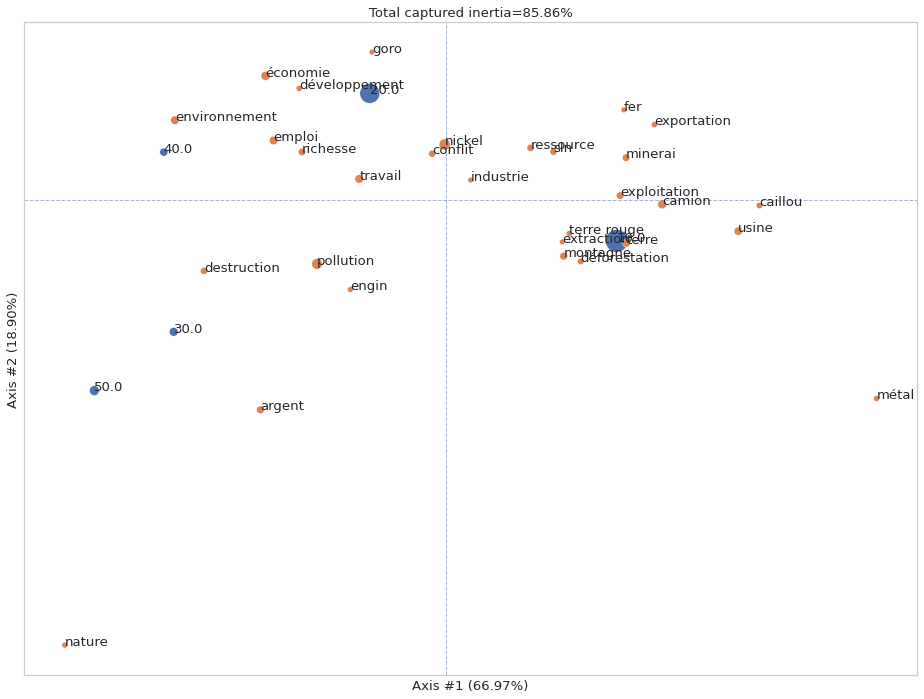

Commune de résidence.,Dumbéa,Hienghène,Mont-Dore,Nouméa,Païta,Yaté
Mot énoncé,,,,,,
argent,8,16,10,11,5,9
caillou,5,7,8,10,3,0
camion,12,33,10,18,2,2
conflit,9,3,14,8,6,6
destruction,10,9,11,10,3,1
déforestation,3,7,11,13,3,0
développement,7,2,3,6,1,5
emploi,12,1,17,29,12,5
engin,2,7,5,5,1,0


<Figure size 1152x864 with 1 Axes>

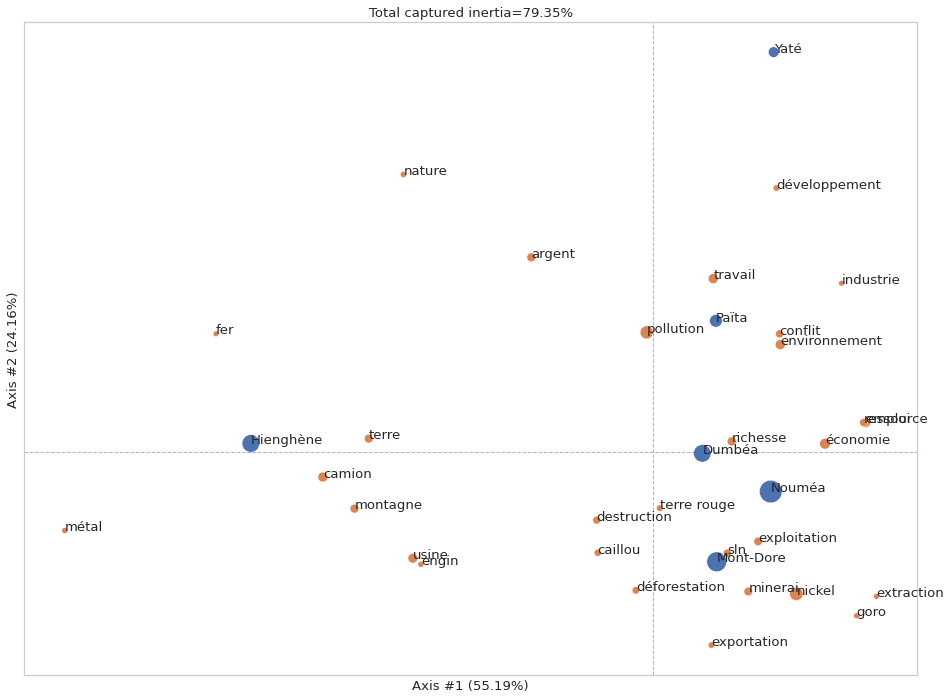

Distinction communes minières ; non-minière et mixte (Nouméa),Minière,Mixte,Non minière
Mot énoncé,,,
argent,29,13,33
caillou,10,10,18
camion,22,21,61
conflit,21,10,21
destruction,21,11,28
déforestation,11,13,18
développement,10,8,12
emploi,29,31,37
engin,9,6,11


<Figure size 1152x864 with 1 Axes>

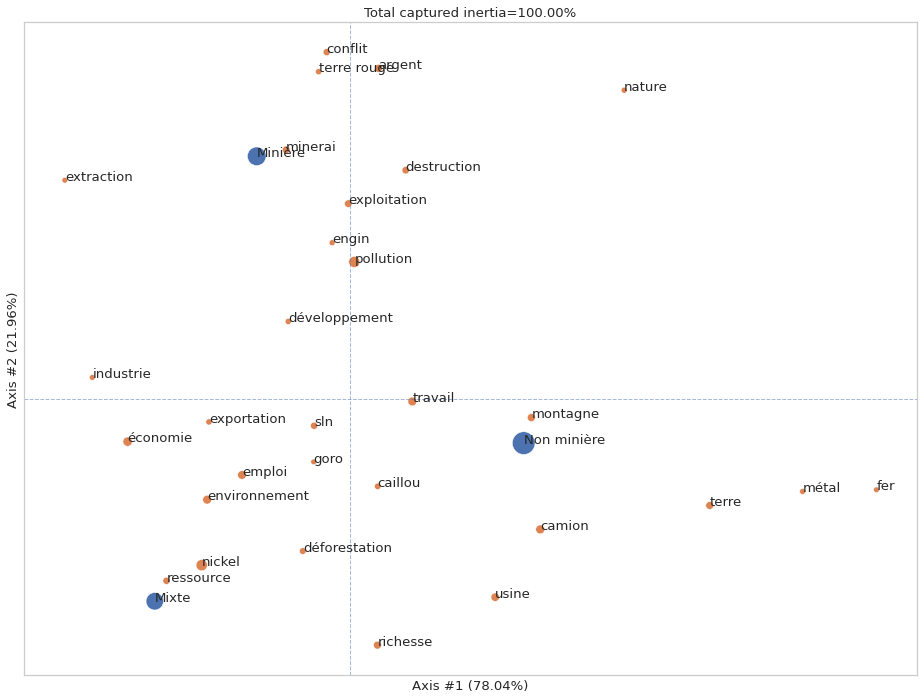

In [48]:
sns.set_theme(style="whitegrid", font_scale=1.10, rc={"figure.figsize": (16, 12)})
ca = CA(42)

for attribut in ["GAD", "Question 8.1", "Question 8.2"]:
    ref = gen_ca_dataset(dict_mine, attribut)
    display(ref.sort_index())
    ca.fit(ref)
    # ca.plot(coords=("principal", "standard"))
    # plt.show()
    # ca.plot(coords=("standard", "principal"))
    # plt.show()
    ca.plot(coords=("principal", "principal"), legend=None)
    plt.show()


Les mêmes, une fois le thésaurus appliqué.

GAD,10.0,20.0,30.0,40.0,50.0
Mot énoncé,,,,,
acteurs internationaux,15,10,1,0,3
"acteurs, institutions, société",8,10,11,5,3
action de détruire - dégrader - transformer,28,26,7,4,10
actions compensatoires du secteur minier,4,6,3,2,8
avantage-bénéfice économique et financier,157,153,28,28,49
avis péjoratifs et interactions négatives,38,38,6,7,13
conditions de travail,14,11,4,3,3
dégradation-impact environnemental négatif,119,98,22,14,33
epuisement des ressources naturelles,11,5,2,1,3


<Figure size 1152x864 with 1 Axes>

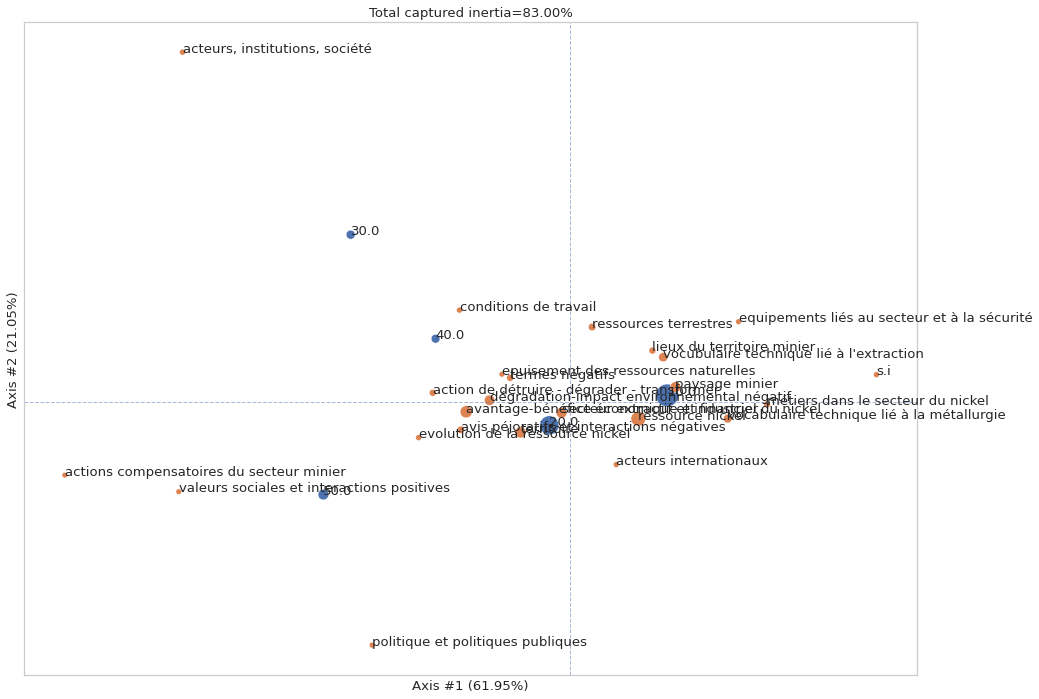

Commune de résidence.,Dumbéa,Hienghène,Mont-Dore,Nouméa,Païta,Yaté
Mot énoncé,,,,,,
acteurs internationaux,7,3,5,4,4,1
"acteurs, institutions, société",1,6,7,8,2,7
action de détruire - dégrader - transformer,12,14,15,14,4,3
actions compensatoires du secteur minier,3,2,4,5,0,2
avantage-bénéfice économique et financier,59,51,64,109,40,31
avis péjoratifs et interactions négatives,11,16,21,24,9,12
conditions de travail,2,8,7,14,0,0
dégradation-impact environnemental négatif,37,46,55,67,20,17
epuisement des ressources naturelles,2,7,4,7,1,0


<Figure size 1152x864 with 1 Axes>

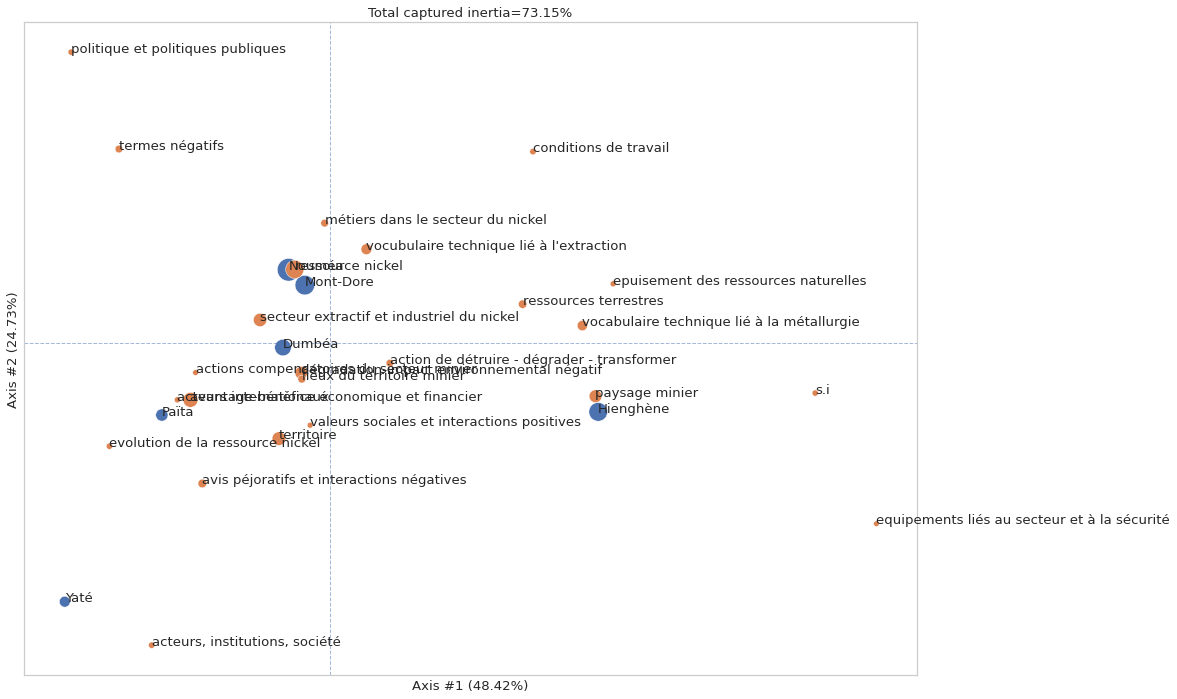

Distinction communes minières ; non-minière et mixte (Nouméa),Minière,Mixte,Non minière
Mot énoncé,,,
acteurs internationaux,6,4,19
"acteurs, institutions, société",21,9,12
action de détruire - dégrader - transformer,27,15,41
actions compensatoires du secteur minier,10,6,8
avantage-bénéfice économique et financier,135,116,186
avis péjoratifs et interactions négatives,40,26,40
conditions de travail,13,14,10
dégradation-impact environnemental négatif,94,75,134
epuisement des ressources naturelles,4,7,11


<Figure size 1152x864 with 1 Axes>

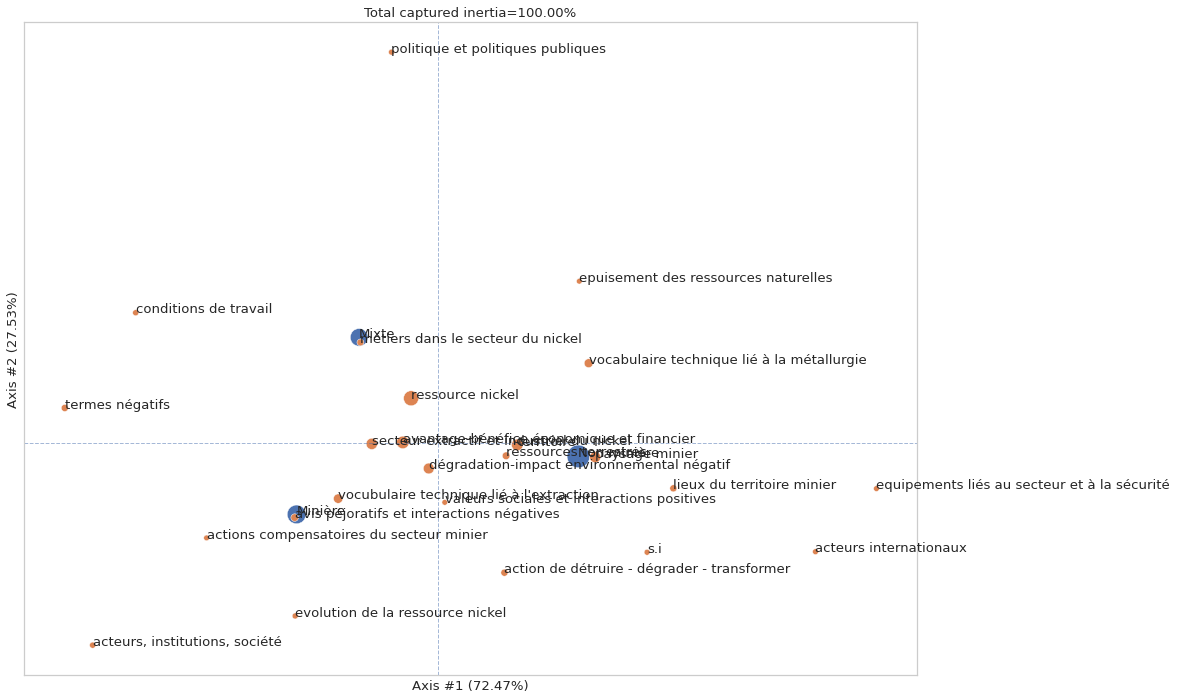

In [49]:
sns.set_theme(style="whitegrid", font_scale=1.10, rc={"figure.figsize": (16, 12)})
ca = CA(42)

for attribut in ["GAD", "Question 8.1", "Question 8.2"]:
    ref = gen_ca_dataset(dict_mine_concept, attribut)
    display(ref.sort_index())
    ca.fit(ref)
    ca.plot(coords=("principal", "principal"), legend=None)
    plt.show()

## distribution des énonciations

On commence par représenter le nombre de mots en fonction du nombre de citations sur une échelle logarithme-logarithme.
Clairement la majorité des mots (plus de 800) ne sont cités qu'une seule fois, mais on veut vérifier si la loi type Zipf est vérifiée sur le jeu de données.

In [114]:
all_words_mine_inv = defaultdict(list)
for k,n in all_words_mine.items():
    all_words_mine_inv[n].append(k) # f"{k}({n})"
# all_words_mine_inv

In [116]:

def mot_enonces_plus_de_k_fois(k):
    """renvoie le nb de motsau dessu sdu seuil et le nombre d'enonciation"""
    d = Counter({c: n for c, n in all_words_mine.items() if n >= k})
    return len(d), d.total(), all_words_mine_inv[k]

# nb_max_enonciations = list(all_words_mine.most_common(1))[0][1]
# nb_max_enonciations

In [133]:
nb_mots_total = len(all_words_mine)
nb_enonciations_total = all_words_mine.total()
res = []
# for i in range(1, nb_max_enonciations+1):
for i in sorted(set(all_words_mine.values())):
    nb_mots, nb_enonciations, mots = mot_enonces_plus_de_k_fois(i)
    row = (
        i,
        nb_mots,
        100 * nb_mots / nb_mots_total,
        nb_enonciations,
        100 * nb_enonciations / nb_enonciations_total,
        sorted(mots)
        # ",".join(sorted(mots)),
    )
    res.append(row)

columns = ["nb occurrences", "nb mots", "% nb mots", "nb énonciations", "% nb énonciations", "mots"]
df_distribution = pd.DataFrame(res, columns=columns)  # .set_index("nb occurrences")
df_distribution.to_excel(output / f"analyse_distribution_enonciations-{today}.xlsx")
display(df_distribution)


,nb occurrences,nb mots,% nb mots,nb énonciations,% nb énonciations,mots
0,1,902,100.000000,3865,100.000000,"[7 nains, ?, abus, achat, acheminement, activi..."
1,2,316,35.033259,3279,84.838292,"[acide, agriculture, amélioration, ancêtre, ar..."
2,3,210,23.281596,3067,79.353169,"[appauvrissement, barrage, blocage, chargement..."
3,4,156,17.294900,2905,75.161708,"[biodiversité, boom, boue, dangereux, division..."
4,5,123,13.636364,2773,71.746442,"[accident, bâteau, bénéfice, chaleur, dégât, d..."
5,6,99,10.975610,2653,68.641656,"[aide, carrière, casque, changement, eau, géol..."
6,7,87,9.645233,2581,66.778784,"[avenir, creuser, employé, four, fumée, matéri..."
7,8,75,8.314856,2497,64.605433,"[arbre, commerce, doniambo, garniérite, gestio..."
8,9,64,7.095344,2409,62.328590,"[chantier, la terre, nouvelle-calédonie, pelle..."
9,10,59,6.541020,2364,61.164295,"[enjeu, sale, scories, transport, travailleur]"


<matplotlib.legend.Legend object at 0x7f3f8c03d930>

<Figure size 1152x864 with 1 Axes>

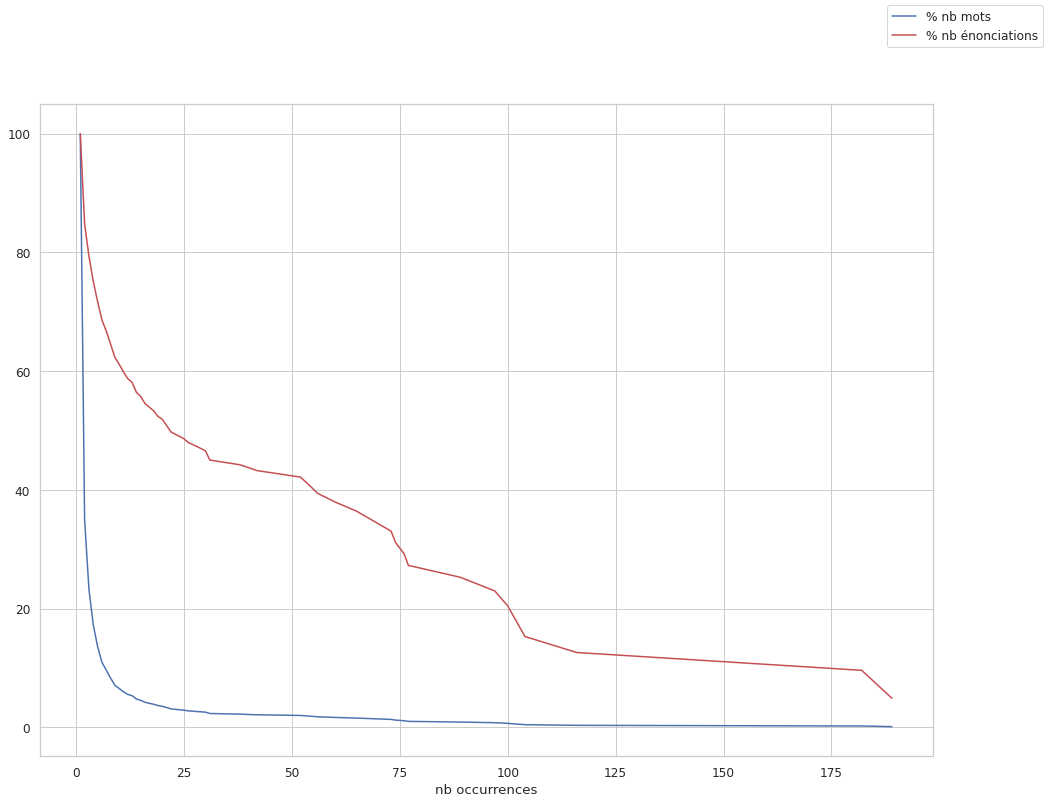

In [134]:
ax = df_distribution.plot(x="nb occurrences", y="% nb mots", legend=False)
df_distribution.plot(x="nb occurrences", y="% nb énonciations", ax=ax, legend=False, color="r")
ax.figure.legend()


### Représentation radiale de la fréquence des mots



In [232]:
cuts = [100, 60, 50, 40, 30, 20, 10, 0]
words = {}
for cut_h, cut_l in pairwise(cuts):
    # print(cut_l, cut_h)
    f = df_distribution["% nb énonciations"].between(cut_l, cut_h)
    # print(df_distribution[f])
    words[(cut_l, cut_h)] = [w for ws in df_distribution[f]["mots"] for w in ws]

# for th, ws in words.items():
#     print(f"Nombre de mots qui représentent entre {th[0]}% et {th[1]}% des énonciations : {len(ws)}")
#     if len(ws) < 50:
#         print(f"\t{', '.join(ws)}")


In [233]:
# tout sauf le premier, dans l'ordre inverse
words_lists = list(words.values())[-1:0:-1]
# words_lists
sizes = list(pairwise(reversed(cuts)))[:-1:]


Nombre de mots qui représentent entre 0% et 10% des énonciations : 2, red
Nombre de mots qui représentent entre 10% et 20% des énonciations : 2, blue
Nombre de mots qui représentent entre 20% et 30% des énonciations : 6, green
Nombre de mots qui représentent entre 30% et 40% des énonciations : 6, pink
Nombre de mots qui représentent entre 40% et 50% des énonciations : 12, black
Nombre de mots qui représentent entre 50% et 60% des énonciations : 26, yellow


<Figure size 1152x864 with 1 Axes>

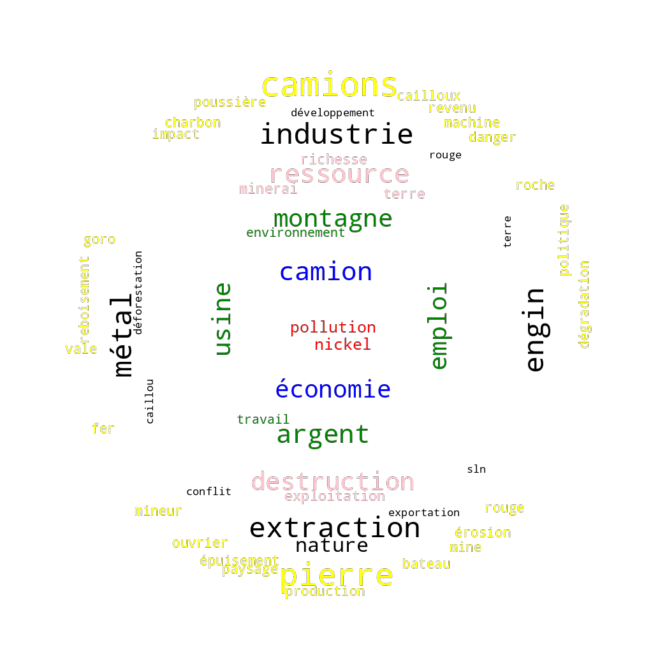

In [235]:
# https://medium.com/analytics-vidhya/delightful-figures-in-python-series-word-cloud-c515901798d2
from wordcloud import WordCloud
from matplotlib.colors import rgb_to_hsv

cmap = ["red", "blue", "green", "pink", "black", "yellow"]

SIZE = 1024

# base mask
x, y = np.ogrid[:SIZE, :SIZE]
distance = (x - SIZE // 2) ** 2 + (y - SIZE // 2) ** 2

plt.axis("off")
K = 0.7
for i, (bounds, ws) in enumerate(zip(sizes, words_lists)):
    low, high = bounds

    mask_outer = distance > (SIZE * (high * K) / 100) ** 2
    mask_inner = distance < (SIZE * (low * K) / 100) ** 2
    mask = 255 * (mask_outer | mask_inner).astype(int)
    the_colour = cmap[i]
    print(f"Nombre de mots qui représentent entre {low}% et {high}% des énonciations : {len(ws)}, {the_colour}")
    wc = WordCloud(
        background_color=None, mode="RGBA", color_func=lambda *args, **kwargs: the_colour, repeat=False, mask=mask
    )
    wc.generate(" ".join(ws))
    plt.imshow(wc, interpolation="bilinear")


# mask = 255 * (~mask_inner).astype(int)
# wc2 = WordCloud(background_color=None, mode="RGBA", repeat=True, mask=mask,  contour_color='steelblue')
# wc2.generate("inner")


# plt.imshow(wc2, interpolation="bilinear")


plt.show()


In [101]:
# sns.histplot(all_words_mine, bins="doane", log_scale=(False, False))
# plt.show()
# sns.histplot(all_words_mine, bins="doane", log_scale=(True, True))
# plt.show()


La petite soeur avec le thésaurus : on voit que la distribution d'origine est _cassée_.

In [122]:
# all_words_mine_concept = Counter(w for l in dict_mine_concept.values() for w in l)
# sns.histplot(all_words_mine_concept, bins="doane", log_scale=(True, True))
# plt.show()

On construit l'histogramme

In [ ]:
y, x = np.histogram(list(all_words_mine.values()), bins = "doane")
df_zipf = pd.DataFrame([y, x], index=["words", "counts"]).T.dropna()
df_zipf["log_words"] = np.log(df_zipf["words"])
df_zipf["log_counts"] = np.log(df_zipf["counts"])
# display(df_zipf)
# sns.lineplot(x = "log_counts", y ="log_words", data = df_zipf)


Maintenant on fait une regression linéaire ordinaire sur le log-log

In [ ]:
data = df_zipf[df_zipf["words"] != 0.0]
model = smf.ols("log_words ~ log_counts", data=data).fit()
display(model.summary())
data["log_words_predict"] = model.predict()
data["words_predict"] = np.exp(model.predict())
display(data)
sns.lineplot(x="log_counts", y="log_words", data=data)
sns.lineplot(x="log_counts", y="log_words_predict", data=data)
plt.show()

# sns.lineplot(x = "counts", y ="words", data = data)
# sns.lineplot(x = "counts", y ="words_predict", data = data)
# plt.show()


### Conclusion

Oui, ça fit assez bien une Zipf.